# VPoser


In [1]:
# Set up environment
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
# %matplotlib inline

from pathlib import Path

import numpy as np
import torch

from tinyhumans.models import SMPLX, VPoser
from tinyhumans.renderer import PyRenderer
from tinytools import image_grid
from tinyhumans.visualize import plot_meshes

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

/home/abenetatos/GitRepos/tinyhumans/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 09-10 16:59:00 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 09-10 16:59:01 [__init__.py:239] Automatically detected platform cuda.


2025-09-10 16:59:02,355	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [2]:
# This tutorial requires 'vposer_v2_05'
support_dir = Path("..", "downloads")
vposer_pretrained_model_path = support_dir / "models" / "vposer" / "model.ckpt"
smplx_pretrained_model_path = support_dir / "models" / "smplx" / "SMPLX_NEUTRAL.npz"
# smplx_pretrained_model_path = support_dir / "SMPLX_NEUTRAL_2020.npz" # same as the other + FLAME face model values are non zero
sample_amass_fname = support_dir / "amass_sample.npz"  # a sample npz file from AMASS

In [3]:
# Load SMPLX and VPoser Model
smplx_model = SMPLX.from_pretrained(pretrained_model_path=smplx_pretrained_model_path, num_betas=10, device_map=device)
vposer = VPoser.from_pretrained(
    vposer_pretrained_model_path,
    remove_key_prefix="vp_model.",
    replace_key_prefixes={"encoder_net.8.mu.": "mu_layer.", "encoder_net.8.logvar.": "logvar_layer."},
    device_map=device,
)

INFO:tinyhumans.models.base_model:Loaded model in evaluation mode from pre-trained weights file: ../downloads/models/vposer/model.ckpt


## Encoding a body_pose (pose>poZ)

We will load an [AMASS](http://amass.is.tue.mpg.de/) sample and place the body pose on the right device for batch processing. To learn more on AMASS data loading refer to [link](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb).


In [4]:
# Prepare the pose_body from amass sample
amass_body_pose = np.load(sample_amass_fname)["poses"][:, 3:66]
amass_body_pose = torch.from_numpy(amass_body_pose).type(torch.float).to(device)
print("amass_body_pose.shape", amass_body_pose.shape)

amass_body_pose.shape torch.Size([500, 63])


In [5]:
amass_body_poZ = vposer.encode(amass_body_pose).mean
print("amass_body_poZ.shape", amass_body_poZ.shape)

amass_body_poZ.shape torch.Size([500, 32])


## Decoding a body_poZ (poZ>pose)

We will decode the same poZ in order to reconstruct the pose and will visualize it for a random frame.


In [6]:
amass_body_pose_rec = vposer.decode(amass_body_poZ)["pose_axis_angles"].contiguous().flatten(-2)
print("amass_body_pose_rec.shape", amass_body_pose_rec.shape)

amass_body_pose_rec.shape torch.Size([500, 63])


In [7]:
##Let's visualize the original pose and the reconstructed one:
t = np.random.choice(len(amass_body_pose))

all_pose_body = torch.stack([amass_body_pose[t], amass_body_pose_rec[t]])

all_pose_body.shape

torch.Size([2, 63])

In [ ]:
betas = torch.randn([2, 10], dtype=torch.float32, device=device)
smplx_output = smplx_model({"body_pose": torch.nn.functional.pad(all_pose_body, (3, 0)), "shape_parameters": betas})
smplx_meshes = smplx_output.get_meshes(smplx_model.faces)[0][0]
fig = plot_meshes(smplx_meshes.to("cpu"), join=True, show=True, subplot_size=800, subplot_titles=None)

In [ ]:
from pytorch3d.structures.pointclouds import Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene

plot_scene(
    {
        "subplot_title": {
            "pointclouds": Pointclouds(smplx_output.joints[0, 0, 0].reshape(1, -1, 3) + 1),
            "mesh": smplx_output.get_meshes(smplx_model.faces)[0][0][0],
        }
    }
)

In [10]:
renderer = PyRenderer(
    image_size=(600, 600),
    bg_color=(0.99, 0.99, 0.99),
    ambient_light=(0.5, 0.5, 0.5),
    use_raymond_lighting=True,
    use_direct_lighting=False,
    camera_params={"translation": [0.0, -0.4, 2.5], "rotation": np.eye(3), "focal_length": 600},
)

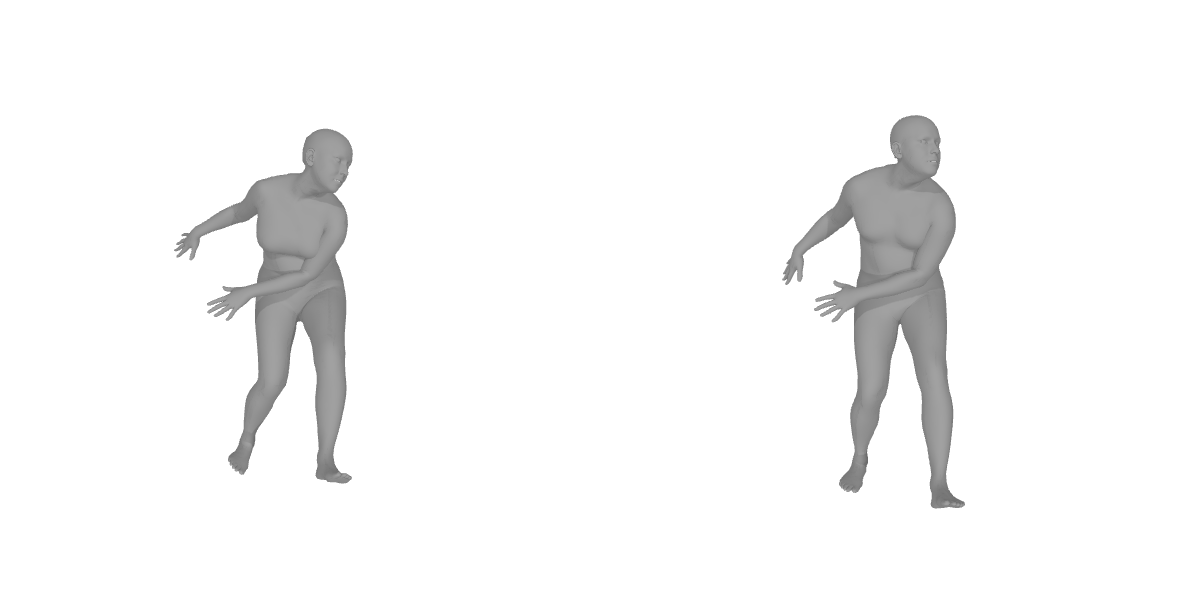

In [11]:
images = [
    renderer(
        mesh,
        render_params={
            "face_normals": False,
            "RGBA": False,
            "segmentation": False,
            "shadows": True,
            "vertex_normals": False,
            "wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes.to_trimesh()
]

image_grid([image[0] for image in images], max_columns=len(images))

The closer above two bodies look similar to each other, the more successful is VPoser is in reconstructing the original data space body pose parameters.


## Generate novel body poses


poZ_body_sample.shape torch.Size([1, 32])
pose_body.shape torch.Size([1, 63])


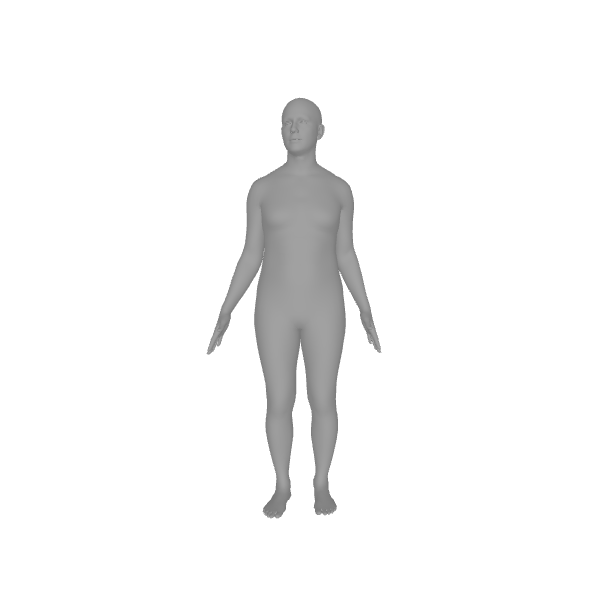

In [12]:
# Sample a 32 dimensional vector from a Normal distribution
poZ_body_sample = torch.from_numpy(np.random.randn(1, 32).astype(np.float32)).to(device)
pose_body = vposer.decode(poZ_body_sample)["pose_axis_angles"].contiguous().view(-1, 63)

print("poZ_body_sample.shape", poZ_body_sample.shape)
print("pose_body.shape", pose_body.shape)

smplx_output = smplx_model({"body_pose": torch.nn.functional.pad(pose_body, (3, 0))})
smplx_meshes = smplx_output.get_meshes(smplx_model.faces)[0][0]

images = [
    renderer(
        mesh,
        render_params={
            "render_face_normals": False,
            "render_in_RGBA": False,
            "render_segmentation": False,
            "render_shadows": True,
            "render_vertex_normals": False,
            "render_wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes.to_trimesh()
]

images[0][0]

Above we drawn a sample from a 32 dimensional Normal distribution and decoded its value to a full 63 dimensional SMPL body pose vector. The generated image shows the corresponding rendered body. Fo an advanced tutorial on generating poses with VPoser refer to [Link](notebooks/vposer_sampling.ipynb).
